# MC-Dropout

## Theoretic Foundation

MC-Dropout is an approximate Bayesian method with sampling. A fixed dropout rate $p \in [0,1)$ is used, meaning that random weights are set to zero during each forward pass with the probability $p$. This models the network weights and biases as a Bernoulli distribution with dropout probability $p$. While commonly used as a regularization method, [Gal, 2016](http://proceedings.mlr.press/v48/gal16.pdf) showed that activating dropout during inference over multiple forward passes yields an approximation to the posterior over the network weights. Due to its simplicity it is widely adopted in practical applications, but MC-Dropout and variants thereof have also been criticized for their theoretical shortcomings [Hron, 2017](https://arxiv.org/pdf/1711.02989.pdf?source=post_page---------------------------) and [Osband, 2016](http://bayesiandeeplearning.org/2016/papers/BDL_4.pdf).

For the MC Dropout model the prediction consists of a predictive mean and a predictive uncertainty. For the predictive mean, the mean is taken over $m \in \mathbb{N}$ forward passes through the network $f_{p,\theta}$ with a fixed dropout rate $p$, resulting in different weights $\{\theta_i\}_{i=1}^m$, given by

$$
     f_p(x^{\star}) = \frac{1}{m} \sum_{i=1}^m  f_{p,\theta_i}(x^{\star}).
$$

The predictive uncertainty is given by the standard deviation of the predictions over $m$ forward passes,

$$
    \sigma_p(x^{\star}) = \sqrt{\frac{1}{m} \sum_{i=1}^m  \left(f_{p,\theta_i}(x^{\star})-  f_p(x^{\star}) \right)^2}.
$$

Note that in [Kendall, 2017](https://proceedings.neurips.cc/paper/2017/file/2650d6089a6d640c5e85b2b88265dc2b-Paper.pdf) the approach is extended to include aleatoric uncertainty. We also consider combining this method with the previous model Gaussian network, as in [Kendall, 2017](https://proceedings.neurips.cc/paper/2017/file/2650d6089a6d640c5e85b2b88265dc2b-Paper.pdf), aiming at disentangling the data and model uncertainties, abbreviated as MC Dropout GMM. For the MC Dropout GMM model,  the prediction again consists of a predictive mean and a predictive uncertainty $f_{p,\theta}(x^{\star}) = (\mu_{p,\theta}(x^{\star}), \sigma_{p,\theta}(x^{\star}))$. Here the predictive mean is given by the mean taken over $m$ forward passes through the Gaussian network mean predictions $\mu_{p,\theta}$ with a fixed dropout rate $p$, resulting in different weights $\{\theta_i\}_{i=1}^m$, given by

$$
     \mu_p(x^{\star}) = \frac{1}{m} \sum_{i=1}^m  \mu_{p,\theta_i}(x^{\star}).
$$

The predictive uncertainty is given by the standard deviation of the Gaussian mixture model obtained by the predictions over $m$ forward passes,

$$
    \sigma_p(x^{\star}) = \sqrt{\frac{1}{m} \sum_{i=1}^m  \left(\mu_{p,\theta_i}(x^{\star})-  \mu_p(x^{\star}) \right)^2 + \frac{1}{m}  \sum_{i=1}^m \sigma_{p,\theta_i}^2(x^\star)}.
$$

## Imports

In [16]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torch.optim import Adam

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import NLL, MCDropoutRegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [4]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [5]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [6]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

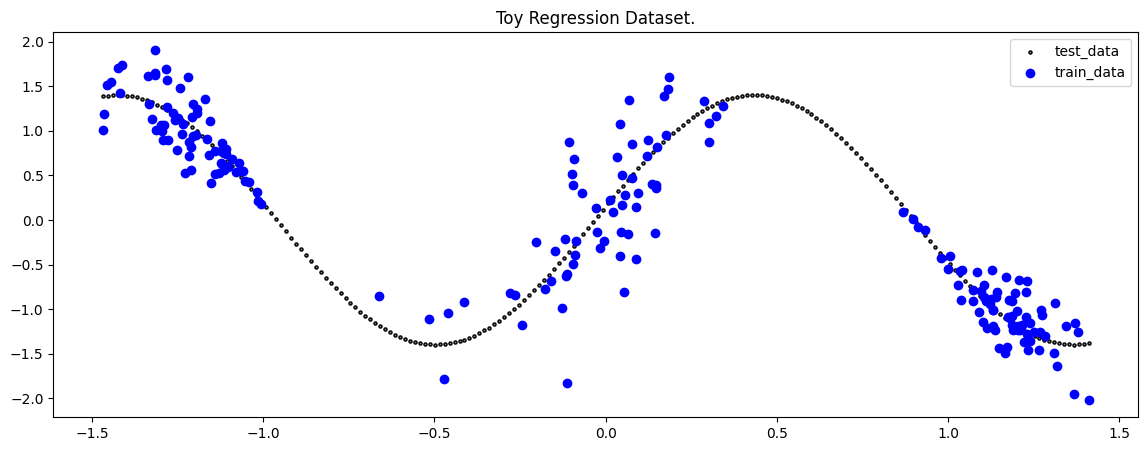

In [7]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP).

In [60]:
network = MLP(
    n_inputs=1,
    n_hidden=[50, 50, 50],
    n_outputs=2,
    dropout_p=0.1,
    activation_fn=nn.Tanh(),
)
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=50, out_features=2, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [61]:
mc_dropout_module = MCDropoutRegression(
    model=network,
    optimizer=partial(Adam, lr=1e-2),
    loss_fn=NLL(),
    num_mc_samples=25,
    burnin_epochs=50,
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [62]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=300,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [63]:
trainer.fit(mc_dropout_module, dm)


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 5.3 K 
1 | loss_fn       | NLL              | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many worke

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

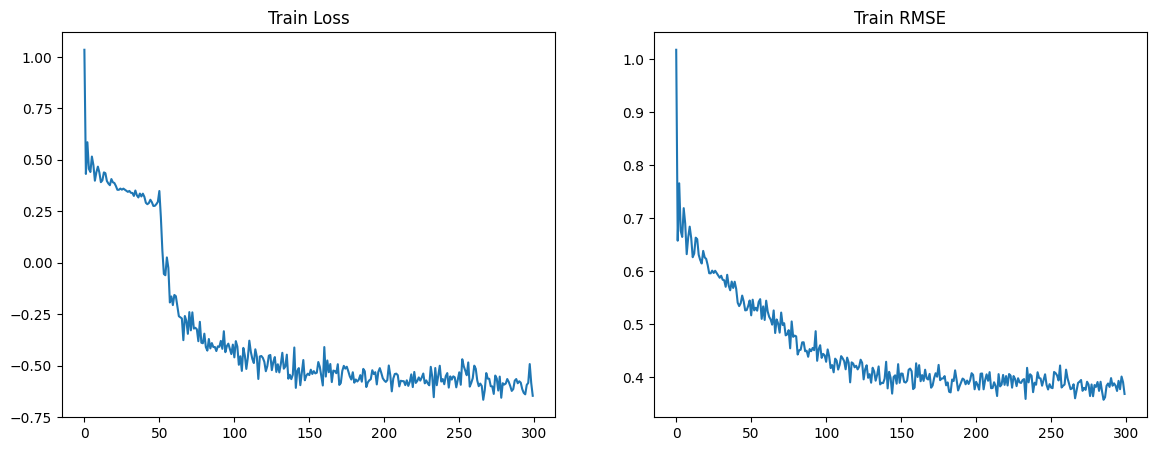

In [64]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "RMSE")

## Prediction

For prediction we can either rely on the `trainer.test()` method or manually conduct a `predict_step()`. Using the trainer will save the predictions and some metrics to a CSV file, while the manual `predict_step()` with a single input tensor will generate a dictionary that holds the mean prediction as well as some other quantities of interest, for example the predicted standard deviation or quantile.

In [65]:
# save predictions
trainer.test(mc_dropout_module, dm.test_dataloader())

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          testMAE          │    0.2094755917787552     │
│          testR2           │    0.9218842387199402     │
│         testRMSE          │    0.28122246265411377    │
└───────────────────────────┴───────────────────────────┘

[{'testMAE': 0.2094755917787552,
  'testR2': 0.9218842387199402,
  'testRMSE': 0.28122246265411377}]

In [66]:
preds = mc_dropout_module.predict_step(X_test)
preds.keys()

dict_keys(['pred', 'pred_uct', 'epistemic_uct', 'aleatoric_uct'])

## Evaluate Predictions

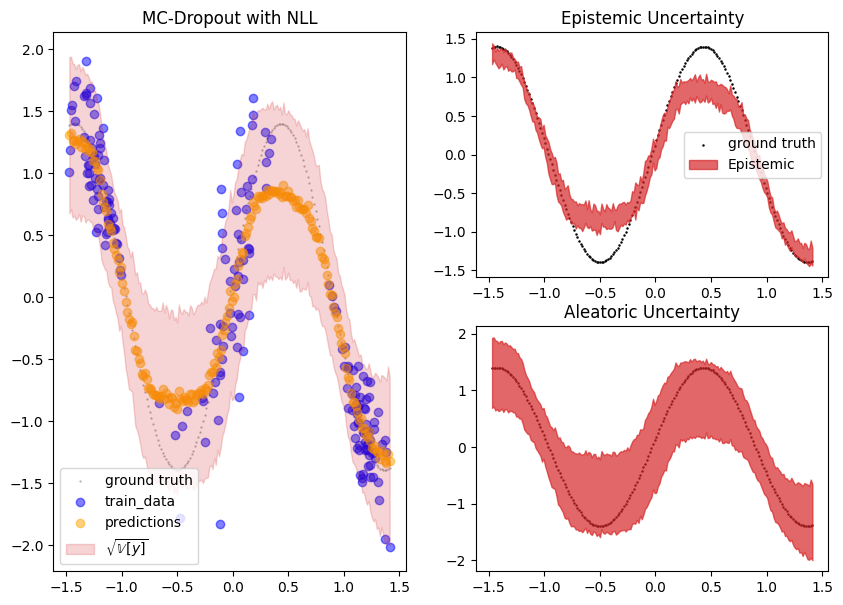

In [67]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="MC-Dropout with NLL",
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

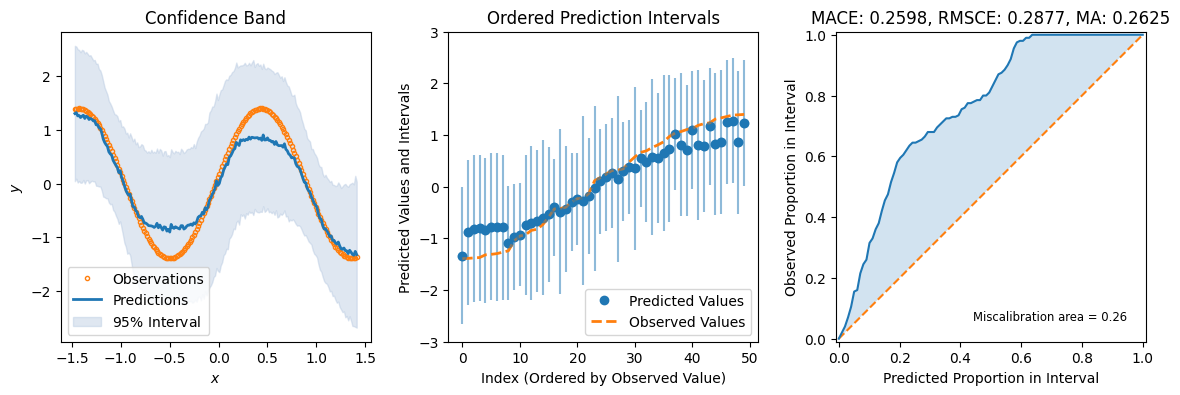

In [68]:
fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"].cpu().numpy(),
    y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)